# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
# установим wget для скачивая файла
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7dc10abbc5f51228745b07a03f0a3bf8a5aba872999eaf3611ef9e40150fc733
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# чтобы не показывались некоторые предупреждения
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# скачиваем файл
import wget

url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv'
filename = wget.download(url)

In [ ]:
# создаем датафрейм с данными
import pandas as pd

df = pd.read_csv(filename)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# делим данные на таргет и признаки
# удаляем также признак salary (очевидно дублирует salary_in_usd в другой валюте)
X = df.drop(['salary', 'salary_in_usd'], axis=1)
y = df['salary_in_usd']

In [ ]:
# делим на трейн, валидационную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                test_size=0.5,
                                                random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math

In [ ]:
# список категориальных фичей
categorical_features = list(X.select_dtypes(include=['object']).columns)

In [ ]:
# значения категориальных признаков
X_train_cat = X_train[categorical_features]
X_val_cat = X_val[categorical_features]
X_test_cat = X_test[categorical_features]

In [ ]:
# список оставшихся фичей
non_categorical_features = list(X.select_dtypes(exclude=['object']).columns)

In [ ]:
# значения оставшихся признаков
X_train_ncat = X_train[non_categorical_features]
X_val_ncat = X_val[non_categorical_features]
X_test_ncat = X_test[non_categorical_features]

In [ ]:
# кодируем категориальные признаки
enc = OneHotEncoder(handle_unknown = 'ignore')

X_train_transformed_cat = enc.fit_transform(X_train_cat)
X_val_transformed_cat = enc.transform(X_val_cat)
X_test_transformed_cat = enc.transform(X_test_cat)

In [ ]:
# объединяем закодированные категориальные признаки с оставшимися
X_train_cat_pd = pd.DataFrame(X_train_transformed_cat.toarray())
X_val_cat_pd = pd.DataFrame(X_val_transformed_cat.toarray())
X_test_cat_pd = pd.DataFrame(X_test_transformed_cat.toarray())

X_train_new = pd.concat([X_train_cat_pd.reset_index(drop=True), X_train_ncat.reset_index(drop=True)], axis=1)
X_val_new = pd.concat([X_val_cat_pd.reset_index(drop=True), X_val_ncat.reset_index(drop=True)], axis=1)
X_test_new = pd.concat([X_test_cat_pd.reset_index(drop=True), X_test_ncat.reset_index(drop=True)], axis=1)

In [ ]:
# создаем общую обучающую выборку
X_tr_full = pd.concat([X_train_new, X_val_new])
y_tr_full = pd.concat([y_train, y_val])

In [ ]:
# предсказываем значения
reg = LinearRegression().fit(np.array(X_tr_full), y_tr_full)
pred_test = reg.predict(np.array(X_test_new))
pred_train = reg.predict(np.array(X_tr_full))

In [ ]:
# смотрим на ошибки на трейне и тесте
print('MAPE train: ', mean_absolute_percentage_error(pred_train, y_tr_full))
print('RMSE train: ', math.sqrt(mean_squared_error(pred_train, y_tr_full)))
print()
print('MAPE test: ', mean_absolute_percentage_error(pred_test, y_test))
print('RMSE test: ', math.sqrt(mean_squared_error(pred_test, y_test)))

MAPE train:  0.3855962787372624
RMSE train:  45336.87088586568

MAPE test:  0.5005449637736095
RMSE test:  4003542698740.8643


Во-первых, заметно очень сильное переобучение модели: на трейне ошибка в обоих случаях заметно выше. Во-вторых, можно сказать, что и на трейне ошибка большая (хотя сама целевая переменная достаточно большого порядка, все равно многовато...) В общем не очень :)

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

In [ ]:
# необходимо для дальнейшего гридсерча, чтобы кроссвалидация проводилась по настоящей валидационной выборке
split_index = [-1]*X_train_new.shape[0] + [0]*X_val_new.shape[0]
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# проводим гридсерч по заданным параметрам
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': np.arange(2, 21, 3),
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [50, 100, 150, 200],
    'gamma': [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

model_xgb = XGBRegressor()

gs = GridSearchCV(model_xgb, params, cv=pds)

In [ ]:
# работает кучу времени, зато много параметров перебирается
%%time
gs.fit(np.array(X_tr_full), y_tr_full)

CPU times: user 30min 24s, sys: 12.2 s, total: 30min 36s
Wall time: 22min 22s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    i...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'gamma': [0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                         'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                         'max_depth': array([ 2,  5,  8, 11, 14, 17, 20]),
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
# смотирм на лучшие параметры
best_params = gs.best_params_
best_params

{'gamma': 0, 'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 200}

In [ ]:
# запоминаем лучшие признаки
max_depth = best_params['max_depth']
learning_rate = best_params['learning_rate']
n_estimators = best_params['n_estimators']
gamma = best_params['gamma']

In [ ]:
# создаем xgbregressor с полученными параметрами
xgb = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)

In [ ]:
# обучаем полученный xgbregressor
%%time
xgb.fit(np.array(X_tr_full), y_tr_full)

CPU times: user 1.46 s, sys: 9.97 ms, total: 1.47 s
Wall time: 772 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# делаем предсказания
%%time
pred_test = xgb.predict(np.array(X_test_new))
pred_train = xgb.predict(np.array(X_tr_full))

CPU times: user 83.7 ms, sys: 945 µs, total: 84.6 ms
Wall time: 58.4 ms


In [ ]:
# смоттрим на ошибки
print('MAPE train: ', mean_absolute_percentage_error(pred_train, y_tr_full))
print('RMSE train: ', math.sqrt(mean_squared_error(pred_train, y_tr_full)))
print()
print('MAPE test: ', mean_absolute_percentage_error(pred_test, y_test))
print('RMSE test: ', math.sqrt(mean_squared_error(pred_test, y_test)))

MAPE train:  0.2445544788017907
RMSE train:  43599.43149398579

MAPE test:  0.272350513744459
RMSE test:  45811.60014453024


Модель переобучилась не так сильно. На таких больших значения таргета можно сказать, что она совсем не переобучилась. Но ошибка все равно большая, хотя сильно лучше по сравнению с линейной моделью. В целом обучение (примерно 1,5с) и предсказание (меньше 1с) достаточно быстрые. Модель более-менее хорошая!

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.4 MB/s eta 0:00:00


In [ ]:
# гридсерч по заданным параметрам
from catboost import CatBoostRegressor

params = {
    'depth' : [3, 8, 13, 16],
    'learning_rate' : [0.01, 0.015, 0.025, 0.05, 0.1],
    'iterations' : [10, 40, 70, 100],
}

model_cb = CatBoostRegressor(logging_level='Silent')

gs = GridSearchCV(model_cb, params, cv=pds)

In [ ]:
# находим лучшие параметры
gs.fit(np.array(X_tr_full), y_tr_full)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f9f12a17d60>,
             param_grid={'depth': [3, 8, 13, 16],
                         'iterations': [10, 40, 70, 100],
                         'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1]})

In [ ]:
# лучшие параметры
best_params = gs.best_params_
best_params

{'depth': 13, 'iterations': 100, 'learning_rate': 0.1}

In [ ]:
# записываем эти лучшие параметры
depth = best_params['depth']
learning_rate = best_params['learning_rate']
iterations = best_params['iterations']

In [ ]:
# создаем catboostregressor
cb = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, logging_level='Silent')

In [ ]:
# обучаем его
%%time
cb.fit(np.array(X_tr_full), y_tr_full)

CPU times: user 5.99 s, sys: 130 ms, total: 6.12 s
Wall time: 3.98 s


In [ ]:
# делаем предсказания
%%time
pred_test = cb.predict(np.array(X_test_new))
pred_train = cb.predict(np.array(X_tr_full))

CPU times: user 27.7 ms, sys: 880 µs, total: 28.5 ms
Wall time: 22 ms


In [ ]:
# смотрим на ошибку
print('MAPE train: ', mean_absolute_percentage_error(pred_train, y_tr_full))
print('RMSE train: ', math.sqrt(mean_squared_error(pred_train, y_tr_full)))
print()
print('MAPE test: ', mean_absolute_percentage_error(pred_test, y_test))
print('RMSE test: ', math.sqrt(mean_squared_error(pred_test, y_test)))

MAPE train:  0.24482819445012455
RMSE train:  43754.69630744511

MAPE test:  0.27407783756754284
RMSE test:  45712.83841498154


Тоже получилась достаточно хорошая модель (очень схожа с предыдущей по значениям метрик-ошибок, даже чуть лучше получилась!). Хотя все равно есть переобучение, оно также небольшое. Обучение было чуть дольше: 6 секунд, а предсказание очень быстрым: 28,5ms.

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
# для дальнейшей кроссвалидации в гридсерче
split_index = [-1]*X_train.shape[0] + [0]*X_val.shape[0]
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# задаем параметры
params = {
    'depth' : [3, 8, 13, 20],
    'learning_rate' : [0.01, 0.015, 0.025, 0.05, 0.1],
    'iterations' : [10, 40, 70, 100],
}

model_cb = CatBoostRegressor(logging_level='Silent')

In [ ]:
# полная трейновая выборка
X_train_f = pd.concat([X_train, X_val])

In [ ]:
# создаем объекты pool для трейновых и тестовых данных
from catboost import Pool

train_data_only = Pool(data=X_train_f, cat_features=categorical_features)
train_data = Pool(data=X_train_f, label=y_tr_full, cat_features=categorical_features)
test_data = Pool(data=X_test, cat_features=categorical_features)

In [ ]:
# применяем гридсерч
grid_search_result = model_cb.grid_search(params,
                                          X=train_data,
                                          cv=pds)

0:	loss: 139454.4216804	best: 139454.4216804 (0)	total: 40.2ms	remaining: 3.18s
1:	loss: 133755.7092710	best: 133755.7092710 (1)	total: 72.8ms	remaining: 2.84s
2:	loss: 123240.1736184	best: 123240.1736184 (2)	total: 118ms	remaining: 3.03s
3:	loss: 101692.4714271	best: 101692.4714271 (3)	total: 141ms	remaining: 2.68s
4:	loss: 74931.7502376	best: 74931.7502376 (4)	total: 164ms	remaining: 2.46s
5:	loss: 110274.6656535	best: 74931.7502376 (4)	total: 253ms	remaining: 3.12s
6:	loss: 95900.2874961	best: 74931.7502376 (4)	total: 363ms	remaining: 3.79s
7:	loss: 76424.5735044	best: 74931.7502376 (4)	total: 492ms	remaining: 4.43s
8:	loss: 56422.1444641	best: 56422.1444641 (8)	total: 576ms	remaining: 4.55s
9:	loss: 50105.0332843	best: 50105.0332843 (9)	total: 676ms	remaining: 4.73s
10:	loss: 90089.3005016	best: 50105.0332843 (9)	total: 866ms	remaining: 5.43s
11:	loss: 74768.8393578	best: 50105.0332843 (9)	total: 1.1s	remaining: 6.25s
12:	loss: 58770.6597935	best: 50105.0332843 (9)	total: 1.35s	rem

In [ ]:
# лучшие параметры
best_pars = grid_search_result['params']
best_pars

{'depth': 13, 'learning_rate': 0.1, 'iterations': 100}

In [ ]:
# сохраняем лучшие параметры
depth = best_params['depth']
learning_rate = best_params['learning_rate']
iterations = best_params['iterations']

In [ ]:
# создаем catboostregressor с лучшими параметрами
cb = CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, logging_level='Silent')

In [ ]:
# обучаем
%%time
cb.fit(train_data)

CPU times: user 5.61 s, sys: 178 ms, total: 5.79 s
Wall time: 3.62 s


In [ ]:
# предсказываем
%%time
pred_test = cb.predict(test_data)
pred_train = cb.predict(train_data_only)

CPU times: user 8.13 ms, sys: 1.92 ms, total: 10.1 ms
Wall time: 23.3 ms


In [ ]:
# смотрим ошибку
print('MAPE train: ', mean_absolute_percentage_error(pred_train, y_tr_full))
print('RMSE train: ', math.sqrt(mean_squared_error(pred_train, y_tr_full)))
print()
print('MAPE test: ', mean_absolute_percentage_error(pred_test, y_test))
print('RMSE test: ', math.sqrt(mean_squared_error(pred_test, y_test)))

MAPE train:  0.24473321599592587
RMSE train:  44018.32350629082

MAPE test:  0.2783633558910186
RMSE test:  45889.30375056255


Переобучение стало, кажется, чуть меньше! Правда, это достигается из-за незначительного увеличения ошибки на трейне. Но в целом модель по-прежнему хорошая. Обучается за 6 секунд, а предсказывает всего за 10,01ms

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
# делаем то же самое для lightgbm
from lightgbm import LGBMRegressor

params = {
    'max_depth': np.arange(2, 21, 3),
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [50, 100, 150, 200],
    'num_leaves': [20, 30, 60]
}

lgb = LGBMRegressor(verbose=-1)

split_index = [-1]*X_train_new.shape[0] + [0]*X_val_new.shape[0]
pds = PredefinedSplit(test_fold = split_index)

gs = GridSearchCV(lgb, params, cv=pds)

In [ ]:
# гридсерч
gs.fit(np.array(X_tr_full), y_tr_full)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LGBMRegressor(verbose=-1),
             param_grid={'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                         'max_depth': array([ 2,  5,  8, 11, 14, 17, 20]),
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [20, 30, 60]})

In [ ]:
# лучшие параметры
best_params = gs.best_params_
best_params

{'learning_rate': 0.025,
 'max_depth': 11,
 'n_estimators': 150,
 'num_leaves': 30}

In [ ]:
# записываем эти лучшие параметры
max_depth = best_params['max_depth']
learning_rate = best_params['learning_rate']
n_estimators = best_params['n_estimators']
num_leaves = best_params['num_leaves']

In [ ]:
# создаем lgbmregressor
lgb = LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, num_leaves=num_leaves, verbose=-1)

In [ ]:
# обучаем
%%time
lgb.fit(np.array(X_tr_full), y_tr_full)

CPU times: user 103 ms, sys: 1.99 ms, total: 105 ms
Wall time: 105 ms


LGBMRegressor(learning_rate=0.025, max_depth=11, n_estimators=150,
              num_leaves=30, verbose=-1)

In [ ]:
# предсказываем
%%time
pred_test = gs.predict(np.array(X_test_new))
pred_train = gs.predict(np.array(X_tr_full))

CPU times: user 62.2 ms, sys: 0 ns, total: 62.2 ms
Wall time: 62.4 ms


In [ ]:
# смотрим ошибку
print('MAPE train: ', mean_absolute_percentage_error(pred_train, y_tr_full))
print('RMSE train: ', math.sqrt(mean_squared_error(pred_train, y_tr_full)))
print()
print('MAPE test: ', mean_absolute_percentage_error(pred_test, y_test))
print('RMSE test: ', math.sqrt(mean_squared_error(pred_test, y_test)))

MAPE train:  0.25947458862906475
RMSE train:  46221.35987146003

MAPE test:  0.2757844062098514
RMSE test:  46128.90417636115


Переобучения нет (если смотреть на rmse, mape все равно на трейне меньше)! Но ошибка в целом чуть больше стала. Зато быстро обучается (105ms) и предсказывает (62,2 ms)!

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

Приведем все данные по моделям в табличке:

|             |XGBoost|Catboost normal|Catboost Pool|LightGBM|
|-------------|-------|---------------|-------------|--------|
|RMSE train   |43599  |43754          |44018        |46221   |
|RMSE test    |45811  |45712          |45889        |46128   |
|MAPE train   |0.24455|0.24483        |0.24473      |0.25947 |
|MAPE test    |0.27235|0.27408        |0.27836      |0.27578 |
|Обучение     |1,47s  |6,12s          |5,79s        |105ms   |
|Предсказание |84,6ms |28,5ms         |10,1ms       |62,2ms  |
|gamma        |0      |-              |-            |-       |
|learning_rate|0,015  |0,1            |0,1          |0,025   |
|max_depth    |8      |-              |-            |11      |
|n_estimators |200    |-              |-            |150     |
|depth        |-      |13             |13           |-       |
|iterations   |-      |100            |100          |-       |
|num_leaves   |-      |-              |-            |30      |


---


Наименьшая RMSE на обучающей выборке у модели XGBoost, а на тестовой -- у обычного (без использования Pool) catboost'a. При этом интересно, что catboost c Pool'ом показывает наименьшее переобучение, там ошибка на тесте даже меньше ошибки на трейне! Затем идет LightGBM, там разница между ошибкой на тесте и трейне очень невиликая, однако сами значения ошибки на пару тысяч больше других моделей. По этому параметру, наверное, лучшей является модель catboost без использования Pool'a, потому что значения ошибки меньше других в целом, хотя по переобучению она всего лишь на третьем месте.


---


Если смотреть на ошибку MAPE, то можно сказать, что в целом у моделей примерно одинаковые результаты, только LightGBM снова имеет несколько большую ошибку на трейне. В целом на трейне минимум снова у XGBoost, как и на тестовых данных. По этой метрике качества XGBoost оказывается лучшей моделью.

---

Быстрее всего обучилась модель LightGBM, а дольше всего -- Catboost без использования Pool'a. Причем LightGBM обучился в разы быстрее других моделей, однако показал наихудшие результаты с точки зрения RMSE.


---

По параметру предсказания все модели примерно одинаково быстры, но Catboost с Pool'ом самый быстрый, а самая медленная модель -- XGBoost.

---

gamma была только в XGBoost, так что сравнивать не с чем :) модель лучше всего работает при самой маленькой из предложенных ей гамм!

---

learning_rate примерно одинаковый у XGBoost и LightGBM, причем ближе к самому маленькому. А вот у catboost'a самый большой из предложенных: 0,1.

---

(кажется, max_depth и depth примерно одно и тоже, так что...) в целом максимальная глубина деревьев от 8 до 13, что не очень много, причем самые неглубокие деревья строит модель XGBoost, а самые глубокие -- модели Catboost.

---

(вроде, n_estimators и iterations тоже +- одно и тоже, так что...) везде от 100 до 200 базовых моделей, что в целом является обычным для этого параметра

---

num_leaves тоже особо не с чем сравнивать, но моделька LightGBM выбрала среднее значение числа листов

В общем тяжело сказать, какая из моделей лучше по всем параметрам: у кого-то маленькое переобучние, но ошибка не наименьшая, кто-то показывает хорошие параметры, но обучается долго. В целом мне понравился скорее XGBoost, у него небольшие значения ошибок, хотя и переобучение большое, но зато он обучается быстро и не то чтобы дает плохие результаты!

В любом случае, все модели градиентного бустинга гораздо лучше линейной модели! :)

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
# открываем данные
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
ratings = ratings.transpose()

Выкиньте строку под названием `user`.

In [ ]:
ratings = ratings.drop(index='user')

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
# заполняем пропуски нулями
ratings.fillna(value=0, inplace=True)

In [ ]:
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
"ross, rick",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans

# применяем kmeans
k_means = KMeans(n_clusters=5, random_state=222)
k_means = k_means.fit(ratings)
clusters = k_means.predict(ratings)

In [ ]:
# сохраняем лейблы
labels = k_means.labels_

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
import numpy as np

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([  1,   1,   2,  18, 978]))

**Ответ:** кластеризация явно не очень: два кластера имеют по одному исполнителю, один -- два, а один кластер получился одной "кучей", где целых 978 исполнителей. Вероятно, такое возможно потому, что неправильно подобрано количество кластеров для кластеризации или все данные были очень неравномерными, из-за чего не удалось найти зависимости

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
inds = np.where(np.unique(labels, return_counts=True)[1] == 1)[0]

In [ ]:
ratings.index[inds]

Index(['the beatles', 'radiohead'], dtype='object')

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
new_df = ratings.sum(axis=1)

In [ ]:
new_df

the beatles           91.844883
radiohead             59.256073
deathcab for cutie    32.716688
coldplay              30.151904
modest mouse          29.381284
                        ...    
michal w. smith        4.476960
群星                     2.594432
agalloch               4.987179
meshuggah              2.154773
yellowcard             1.599446
Length: 1000, dtype: float64

**Ответ:** явно выделяются группы the beatles и radiohead по количеству прослушиваний: их значения отличаются от других в 2 или три раза. Поэтому они и кластеризуются отдельно от других, а оставшиеся идут боле-менее равноверным списком

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

# нормализация
ratings_normalized = normalize(ratings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
# заново кластеризуем
k_means = KMeans(n_clusters=5, random_state=222)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

In [ ]:
# снова лейблы
labels = k_means.labels_

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([145, 202, 333, 253,  67]))

**Ответ** теперь распределение исполнителей в каждом классе более похоже на естественное: не выделяются четко какие-то один-два исполнителя в отдельный класс. Наверное, такая кластеризация может быть полезной

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine

centroids = k_means.cluster_centers_

In [ ]:
# информация о всех кластерах
clusters = {}

# для каждого исполнителя
for i in range(len(np.array(ratings))):
    # смотрим, к какому кластеру он относится
    for k in range(5):
        if labels[i] == k:
            # затем добавляем в общий словарь косинусное расстояние до центроида
            if k not in clusters:
                cos = cosine(centroids[k], np.array(ratings_normalized)[i])
                clusters[k] = {ratings.index[i]: cos}
            else:
                cos = cosine(centroids[k], np.array(ratings_normalized)[i])
                clusters[k][ratings.index[i]] = cos

In [ ]:
# выводим для каждого кластера исполнителей
for k in sorted(clusters.keys()):
    print(f'cluster: {k}\n{sorted(clusters[k].items(), key=lambda x:x[1], reverse=True)[:10]}')
    print()

cluster: 0
[('andrew jackson jihad', 0.9083433500159348), ('dead kennedys', 0.9036668211272436), ('kevin devine', 0.899620554363374), ('lucero', 0.8954585256978758), ('the buzzcocks', 0.8915563008392918), ('social\xa0distortion', 0.8892035404998064), ('capn jazz', 0.8814420930480674), ('rx bandits', 0.873327791059771), ('minor threat', 0.8632583294656938), ('yellowcard', 0.8630769449949636)]

cluster: 1
[('reatard, jay', 0.9092079803860486), ('sondre lerche', 0.9031514893267026), ('owen', 0.9001553494424842), ('passion pit', 0.8956783497368365), ('gang of four', 0.8901122538331504), ('ryan adams and the cardinals', 0.8886180296590365), ('mattandkim', 0.8879127812317911), ('kimya dawson', 0.8868032624597029), ('the kills', 0.8864920646536413), ('frightened rabbit', 0.8858526139048611)]

cluster: 2
[('refused', 0.9624923802420825), ('보아', 0.9617212826445329), ('pepper', 0.9616433180389855), ('josh ritter', 0.9569305107884315), ('le tigre', 0.9559997525787234), ('mstrkrft', 0.952452234573

**Ответ:** кажется, получившиеся кластеры можно проинтерпретировать по +- схожем жанрам. Пользователи с одинаковыми вкусами слушают одинаковых исполнителей в примерно одинаковых жанрах, а они группируются в связи с этим

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.gridspec as gridspec
import itertools

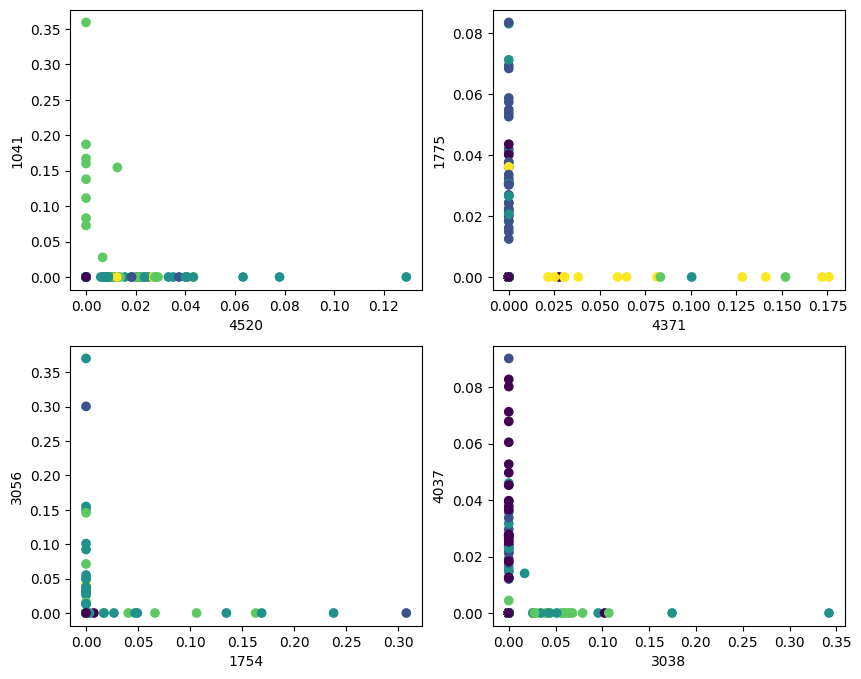

In [ ]:
# задаем сетку
gs = gridspec.GridSpec(2, 2)

# задаем размер общего графика
fig = plt.figure(figsize=(10,8))

# для каждого графика
for grd in itertools.product([0, 1], repeat=2):
    # задаем subplot
    ax = plt.subplot(gs[grd[0], grd[1]])
    # строим картинку
    # выбираем случайные два признаки
    features = random.choices(ratings.columns, k=2)
    # рисуем скаттерплот
    x = ratings_normalized.T[features[0]]
    y = ratings_normalized.T[features[1]]
    fig = plt.scatter(x, y, c=labels)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
# выводим график
plt.show()

**Ответ:** в целом, кажется, два случайных признака дают не самые лучшие результаты. Хотя например, на втором графике заметно явная группировка желтых признаков внизу, а на первом -- вдоль нулевого значения признака по оси x, такие данные не дадут много информации и представления о данных (особенно когда их аж 5000 столбцов, как здесь)

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

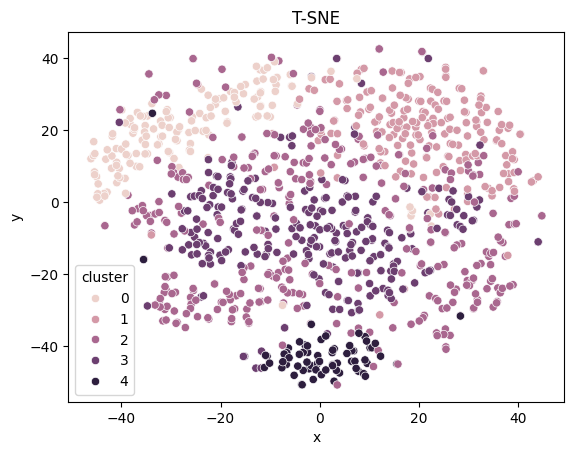

In [ ]:
from sklearn.manifold import TSNE

# визуализируем при помощи tsne
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(ratings_normalized)
k_means = KMeans(n_clusters=5, random_state=222)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)
tsne2D_df = pd.DataFrame(data=tsne_data2D, columns=['x', 'y'])

tsne2D_df['cluster'] = clusters

# рисуем scatterplot
sns.scatterplot(x='x', y='y', hue='cluster', data=tsne2D_df)
plt.title("T-SNE")
plt.show()

По этому графику уже гораздо лучше заметно выделение кластеров: например, четко выделяется 4 кластер внизу (хотя и с небольшими выбросами), 0 кластер сверху слева, 1 кластер справа сверху.

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

# смотрим на каждое из возможных значений кластеров (от 2 до 100)
best_k, best_score = None, -1
for k in range(2, 100):
    # делаем кластеризацию для каждого значения k
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means = k_means.fit(ratings_normalized)
    clusters = k_means.predict(ratings_normalized)
    # смотрим на индекс Силуэта и сравниваем с предыдущими
    score = np.round(silhouette_score(X=ratings_normalized,
                             labels=clusters), 2)
    if score > best_score:
      best_score = score
      best_k = k
print(best_k)

95


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# проведем кластеризацию с лучшим числом кластеров из предыдущего задания
k_means = KMeans(n_clusters=best_k, random_state=42)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

In [ ]:
# все лейблы
labels = k_means.labels_

In [ ]:
# центроиды
centroids = k_means.cluster_centers_

In [ ]:
# информация о всех кластерах
clusters = {}

# для каждого исполнителя
for i in range(len(np.array(ratings))):
    # смотрим, к какому кластеру он относится
    for k in range(best_k):
        if labels[i] == k:
            # затем добавляем в общий словарь косинусное расстояние до центроида
            if k not in clusters:
                cos = cosine(centroids[k], np.array(ratings_normalized)[i])
                clusters[k] = {ratings.index[i]: cos}
            else:
                cos = cosine(centroids[k], np.array(ratings_normalized)[i])
                clusters[k][ratings.index[i]] = cos

In [ ]:
# выводим для каждого кластера исполнителей
for k in sorted(clusters.keys()):
    print(f'cluster: {k}\n{sorted(clusters[k].items(), key=lambda x:x[1], reverse=True)[:10]}')
    print()

cluster: 0
[('manchester orchestra', 0.6806903667662276), ('why?', 0.6543977165938364), ('owen', 0.6483792820119275), ('four year strong', 0.6444733817690095), ('coheed and cambria', 0.6365363745788053), ('the blood brothers', 0.6248036229956082), ('citya and colour', 0.5991574473671069), ('cursive', 0.564720959841152), ('portugal. the man', 0.5301591487493605), ('circa survive', 0.4618848194738304)]

cluster: 1
[('silver jews', 0.6203003609138623), ('the verve', 0.5409959724186897), ('the dandy warhols', 0.5259666268545783), ('black rebel motorcycle club', 0.4722572714593224), ('spiritualized®', 0.4675401007901119), ('the brian jonestown massacre', 0.4108666445327809)]

cluster: 2
[('kimya dawson', 0.7495346509606129), ('bonobo', 0.7032477622963857), ('björk guğmunsdóttir', 0.6680898451176036), ('burial', 0.6667306533169592), ('rjd2', 0.6611135124869779), ('underworld', 0.6452633716069442), ('prefuse 73', 0.5586222211654869), ('aphex twin', 0.5207117930501788), ('boards of canada', 0.

**Ответ:** посмотрим, например, на 51 кластер. Там есть исполнитель enigma, который достаточно близко к центроиду кластера (одно из самых больших получившихся значений здесь), а вот оставшиеся исполнители получились значительно дальше по косинусному расстояния от центроида. Если смотреть на исполнителей, которые в большей степени составляют этот кластер, то они, как правило, исполняют музыку в жанре рок, что, вероятно, служит одной из причин их объединения. То есть слушатели могут предпочитать какой-то один жанр (например, рок), то есть примерно одинаковых исполнителей, а, значит, по этому признаку группируют их

Сделайте t-SNE визуализацию полученной кластеризации.

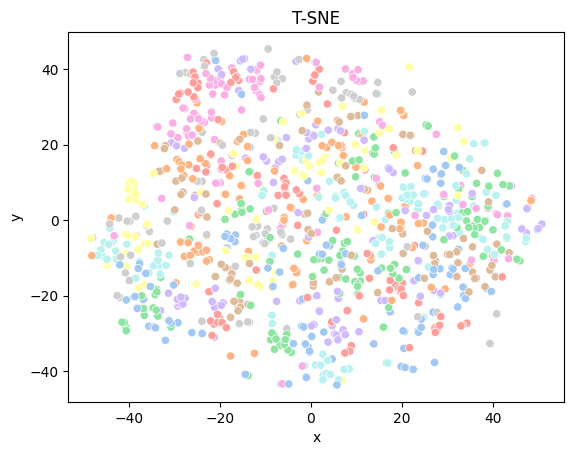

In [ ]:
# общая кластеризация
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(ratings_normalized)
tsne2D_df = pd.DataFrame(data=tsne_data2D, columns=['x', 'y'])

k_means = KMeans(n_clusters=best_k, random_state=42)
k_means = k_means.fit(ratings_normalized)
clusters = k_means.predict(ratings_normalized)

tsne2D_df['cluster'] = clusters

sns.scatterplot(x='x', y='y', hue='cluster', data=tsne2D_df, legend=False, palette="pastel")
plt.title("T-SNE")
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

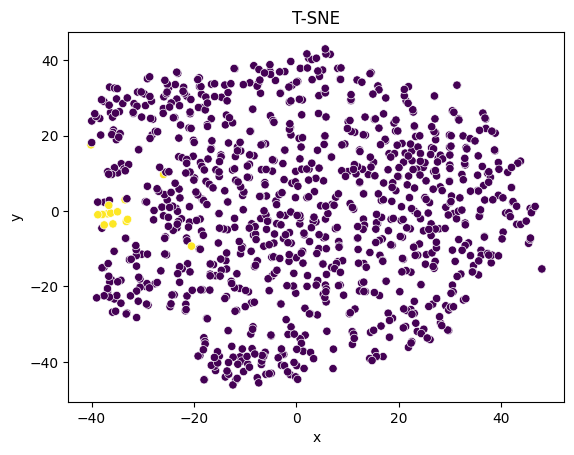

In [ ]:
# посмотрим на тот самый 51 кластер
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(ratings_normalized)
tsne2D_df = pd.DataFrame(data=tsne_data2D, columns=['x', 'y'])

tsne2D_df['cluster'] = clusters

sns.scatterplot(x='x', y='y', c=(labels==51), data=tsne2D_df)
plt.title("T-SNE")
plt.show()

**Ответ:** кластер выделяется достаточно хорошо, учитывая тот факт, что мы уменьшаем размерность. Хотя там и есть некоторые точки, далекие от кластера (кстати, именно поэтому, видимо, расстояния от центра получились большими), большинство точек сгруппированно достаточно кучно друг с другом (видимо, исполнители, наиболее схожие друг с другом: например, группы creed и hoobastank)